# Обучение однослойного персептрона методом коррекции по ошибке через дельта-правило


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!ls drive/MyDrive/labs/
PATH = '/content/drive/MyDrive/labs'
print(PATH + '/Train')


mnist.npz  Test  Train
/content/drive/MyDrive/labs/Train


### предобработка данных

In [28]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(PATH+'/Train', transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))

картинки имеют 3 канала, выбираем любой один

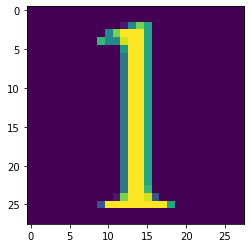

In [29]:
plt.imshow(images[0][0])

In [30]:
images = images[:, 0]
images = images.reshape(24, 28*28)

##№ Архитектура сети:


Входной слой: 784 x 1 \\ Метод обучения: дельта-правило


In [31]:
import torch
from torch.nn import Linear

In [32]:
input_size = 784
output_size = 1

In [33]:
mlp = torch.nn.Sequential(
    Linear(input_size, output_size)
).to('cuda')

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adadelta(mlp.parameters(), lr=learning_rate)
num_epoch = 5000

In [34]:
train_data = torch.cuda.FloatTensor(images.numpy(), device='cuda')
train_labels = torch.cuda.FloatTensor(labels.numpy(), device='cuda')

loss_curve = []
for epoch in range(num_epoch):
    y_pred = mlp(train_data)
    loss = loss_fn(y_pred.reshape(-1), train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:

        print('Epoch:', epoch, 'Loss:', loss.item())
        loss_curve.append(loss.item())
    

Epoch: 0 Loss: 8.734559059143066
Epoch: 50 Loss: 8.59416389465332
Epoch: 100 Loss: 8.43310260772705
Epoch: 150 Loss: 8.256653785705566
Epoch: 200 Loss: 8.067907333374023
Epoch: 250 Loss: 7.869389533996582
Epoch: 300 Loss: 7.66324520111084
Epoch: 350 Loss: 7.451326370239258
Epoch: 400 Loss: 7.2352423667907715
Epoch: 450 Loss: 7.016389846801758
Epoch: 500 Loss: 6.796010494232178
Epoch: 550 Loss: 6.575192451477051
Epoch: 600 Loss: 6.354894638061523
Epoch: 650 Loss: 6.135959625244141
Epoch: 700 Loss: 5.919119834899902
Epoch: 750 Loss: 5.705026149749756
Epoch: 800 Loss: 5.494235992431641
Epoch: 850 Loss: 5.287223815917969
Epoch: 900 Loss: 5.084395408630371
Epoch: 950 Loss: 4.886101722717285
Epoch: 1000 Loss: 4.6926422119140625
Epoch: 1050 Loss: 4.504262447357178
Epoch: 1100 Loss: 4.3211469650268555
Epoch: 1150 Loss: 4.143424034118652
Epoch: 1200 Loss: 3.9711647033691406
Epoch: 1250 Loss: 3.804403305053711
Epoch: 1300 Loss: 3.6431567668914795
Epoch: 1350 Loss: 3.487431287765503
Epoch: 1400 L

Text(0, 0.5, 'loss')

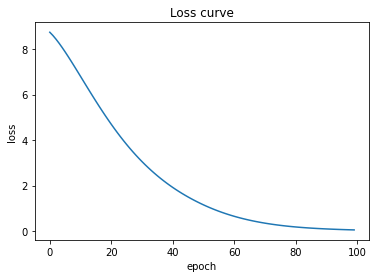

In [35]:
from matplotlib import pyplot as plt

plt.plot(loss_curve)
plt.title('Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')

In [36]:
from sklearn.metrics import accuracy_score
preds = y_pred.detach().cpu().numpy().round()
print("Точность на обучении:", accuracy_score(train_labels.detach().cpu().numpy(), preds))

Точность на обучении: 0.9583333333333334


### Тестирование:

In [37]:
test_dataset = datasets.ImageFolder(PATH+'/Test', transform=transform)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
test_images, test_labels = next(iter(dataloader))

test_images = test_images[:, 0]
test_images = test_images.reshape(6, 28*28)

In [38]:
test_data = torch.cuda.FloatTensor(test_images.numpy(), device='cuda')
test_preds = mlp(test_data).detach().cpu().numpy().round()

In [39]:
print("Точность на тесте:", accuracy_score(test_labels.numpy(), test_preds))

Точность на тесте: 0.8333333333333334


### ошибка

In [40]:
test_labels = test_labels.numpy().astype(int)
test_preds = test_preds.reshape(-1).astype(int)

In [41]:
wrong_ans = test_preds != test_labels
bad_classification_X = test_data[wrong_ans]
wrong_preds = test_preds[wrong_ans]

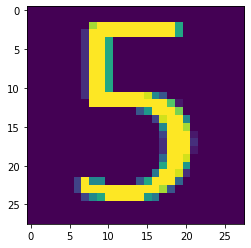

In [43]:
plt.imshow(bad_classification_X.cpu().detach().numpy().reshape(28, 28))

In [44]:
print("Модель считает, что это", wrong_preds[0])

Модель считает, что это 4


### Выводы:

Сеть данной архитектуры решает нашу задачу как задачу регрессии, что говорит о том, что изображения цифр оказались хорошо линейно разделимы в пространстве векторов размера 784. \\

Датасет слишком мал, для каких либо выводох. Сеть переобучилась на тренировочную выборку (что видно по лосс-кривой), и может выдавать ответы только на данных, очень похожих на тренировочные.